<a href="https://colab.research.google.com/github/kariniskandarani/Bikes_in_SN_TimeSeries_P1/blob/master/TS_P1_Bike_Rides_in_San_Francisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pilot Project: Bike Rides in San Francisco


###**Case Study:** Analyzing & Forecasting the number of bike rides in San Francisco
**Objective:** The goal of this challenge is to let you dive deep into time-series signals, analyze it and determine the best predictive model.
The challenge is divided into 2 parts:

* **Part A:** Use time-series data of the number of bike rides in San Francisco and analyze it to better understand it and choose one of the statistical models to predict future values.


* **Part B:** Prepare the same data and structure it in order to train an RNN to predict the number of bike rides for the next 7 days.



##Part A: Time-series analysis and forecasting



## Time-series Analysis



### Importing the libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statistics import mean
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX



import warnings
warnings.filterwarnings('ignore')



### Data Loading & Visualization


In [ ]:
#load dataset
bike_rides_df = pd.read_csv('/content/Bike Rides aggregated.csv')
#convert dtype of date col to be datetime
bike_rides_df['date'] = pd.to_datetime(bike_rides_df['date'])
#set the index of dataframe to be date col
bike_rides_df.set_index('date', inplace=True)

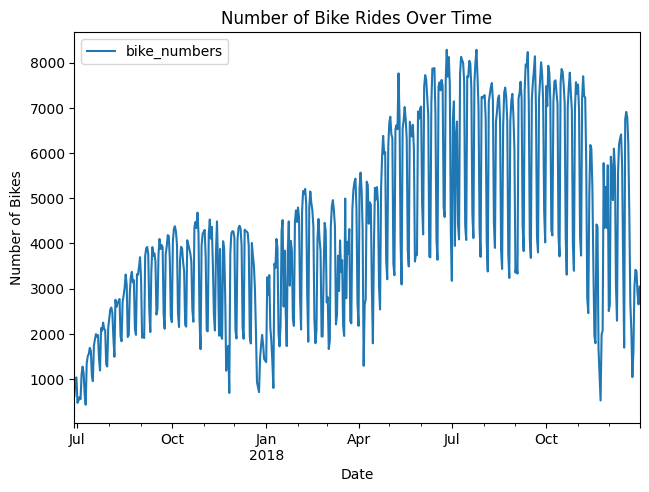

In [ ]:
# Plotting
bike_rides_df.plot()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.xlabel('Date')
plt.ylabel('Number of Bikes')
plt.title('Number of Bike Rides Over Time')
plt.show()




Based on the above plot, the number of bike rides is maximum during July and October 2018 and minimum during January 2018.

In [ ]:
#display the first five rows of the dataframe
bike_rides_df.head()

,bike_numbers
date,
2017-06-28,632
2017-06-29,1019
2017-06-30,1038
2017-07-01,475
2017-07-02,523


In [ ]:
bike_rides_df.shape
print(f'The dataset has {bike_rides_df.shape[0]} rows and {bike_rides_df.shape[1]} columns.')

The dataset has 552 rows and 1 columns.


### Data Decomposition
The statsmodels library provides an implementation of the decomposition method in a function called seasonal_decompose(). Use it to decompose your data and specify the model to be additive.



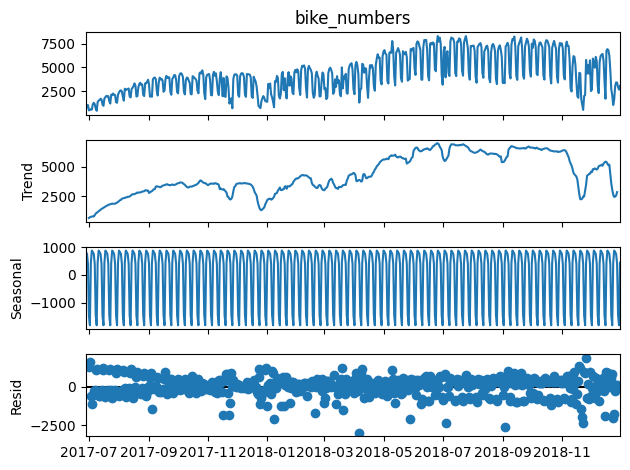

In [ ]:
decomposition = seasonal_decompose(bike_rides_df['bike_numbers'], model='additive')
decomposition.plot()
plt.show()


*   **The trend component in the data is not stable and does not evolve in a consistent manner. Specifically, the trend component exhibits an upward movement over time, peaking around mid-to-late 2018, followed by a decline beginning in November 2018. This pattern suggests that bike usage could be influenced by external factors, such as seasonal weather conditions or other environmental variables.**

*   **In the seasonality component, we observe repeated patterns on a weekly basis. The frequent repetitions suggest a shorter periodicity than monthly indicating a seasonal effect tied to weekly cycles.**

*   **In the residual component, noise and short-term fluctuations  are not systematic and unpredictable.**








### Autocorrelation
To better understand time-series, we need to study its autocorrelation which gives us an idea on how lags are affecting current/future values.


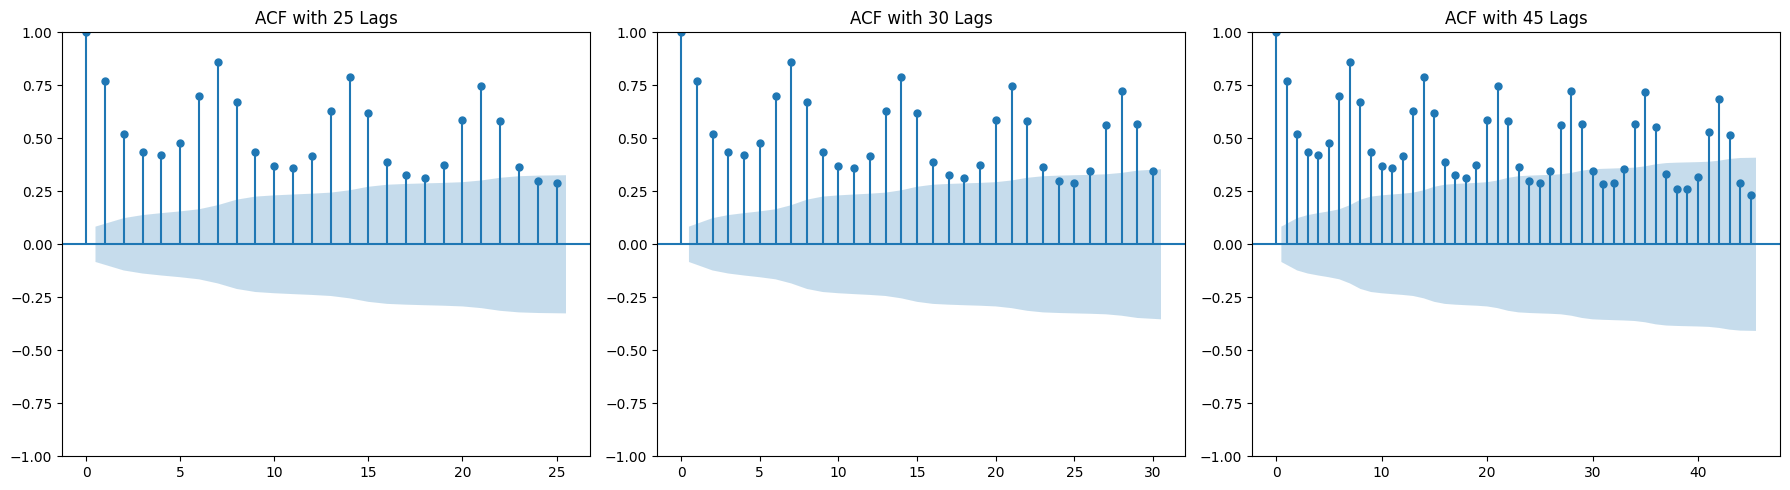

In [ ]:
#  a 1-row, 3-column figure
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot ACF for different lags in each subplot
plot_acf(bike_rides_df['bike_numbers'], lags=25, ax=axs[0])
axs[0].set_title("ACF with 25 Lags")

plot_acf(bike_rides_df['bike_numbers'], lags=30, ax=axs[1])
axs[1].set_title("ACF with 30 Lags")

plot_acf(bike_rides_df['bike_numbers'], lags=45, ax=axs[2])
axs[2].set_title("ACF with 45 Lags")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


**Note:** Since the time series exhibits weekly seasonality, I used 25 lags to cover 25 days, 30 lags to represent a month, and 45 lags to cover 45 days (a month and 15 days). These values were chosen to analyze the data from a broader perspective. Additionally, 14 lags can be used to cover two seasonal cycles. Therefore, the selection of lags was guided by the observed seasonality patterns.

**The ACF plots reveal strong evidence of seasonality in the time series. This is supported by the presence of a sinusoidal pattern across multiple lags and the observation of significant spikes at regular intervals (lags 7, 14, 21, etc.), suggesting a weekly seasonal cycle. Furthermore, the autocorrelation values remain significantly above the confidence threshold for numerous lags, indicating a strong autocorrelation structure within the time series.**




### Partial Autocorrelation
To better understand time series, we need to study its partial autocorrelation, which gives us an idea of how lags affect current/future values without having the in-between-lags effect.


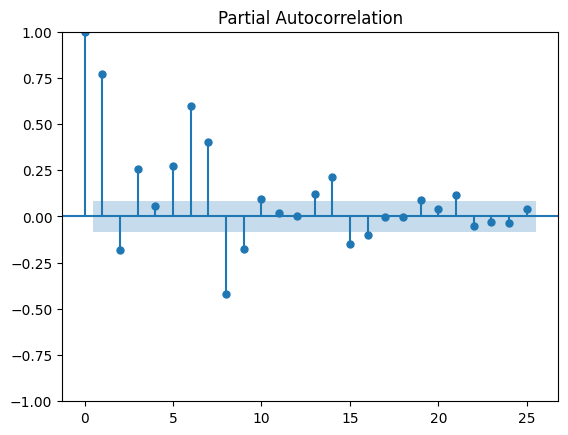

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(bike_rides_df['bike_numbers'], lags=25)
plt.show()



**Based on the above PACF plot,**


*   **The first lag has a strong positive correlation, indicating that the previous time step is a good predictor of the current value.**
*   **The presence of several significant lags suggests a higher-order AR process.**


*   **After around lag 10, the correlations drop within the confidence interval, implying that the direct influence weakens beyond this point.**
*   **The presence of negative values at some lags suggests possible oscillations in the data.**





In [ ]:
# Perform Ljung-Box Q-test
ljung_box_results = acorr_ljungbox(bike_rides_df['bike_numbers'], lags=[7, 14, 21], return_df=True)

# Display the test results
print("Ljung-Box Q-Test Results:")
print(ljung_box_results)


Ljung-Box Q-Test Results:
        lb_stat  lb_pvalue
7   1500.574511        0.0
14  2692.690962        0.0
21  3711.053580        0.0


**I applied the Ljung-Box Q-test, a statistical method used to detect autocorrelation in a time series at various lags. Since the p-value is less than 0.05, we reject the null hypothesis, indicating that the data is not random and the selected lags show significant autocorrelation.**

##Check TS for Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test to check if the bike_rides_df  is stationary
#Check stationarity
result = adfuller(bike_rides_df['bike_numbers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")


ADF Statistic: -2.130982
p-value: 0.232241
Fail to reject the null hypothesis: The time series is non-stationary.


Based on the above ADF test, the time series is non-stationary.

## Time-series Forecasting
The goal of this section is to use the previous analysis to determine which of the statistical models you learned through the week.



### Simple moving average

Applying a simple moving average filter on the data with a window of size 20.

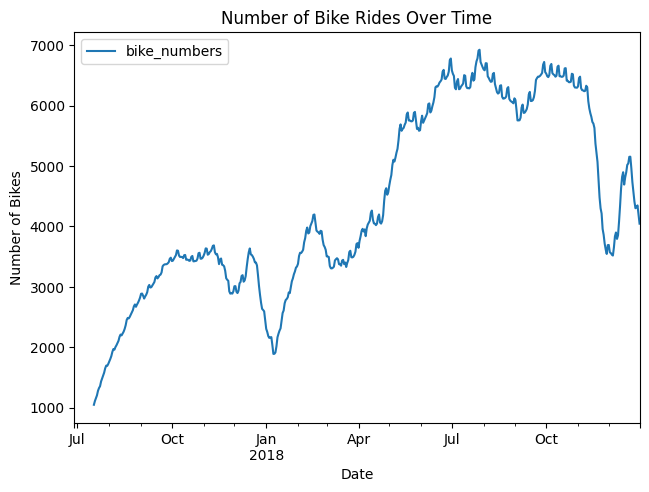

In [ ]:
#applying a moving average filter with window size of 20 to a copy of the original data frame
avg_bike_rides_df= bike_rides_df.rolling(window=20).mean()
#displaying the dataset
avg_bike_rides_df.plot()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.xlabel('Date')
plt.ylabel('Number of Bikes')
plt.title('Number of Bike Rides Over Time')
plt.show()

In [ ]:
avg_bike_rides_df.head(30)

,bike_numbers
date,
2017-06-28,NaN
2017-06-29,NaN
2017-06-30,NaN
2017-07-01,NaN
2017-07-02,NaN
2017-07-03,NaN
2017-07-04,NaN
2017-07-05,NaN
2017-07-06,NaN


**In the above dataset (avg_bike_rides_df), we notice that the first 19 rows are NAN because we applied the moving average with window size of 20.**

In [ ]:
bike_rides_df.shape

(552, 1)

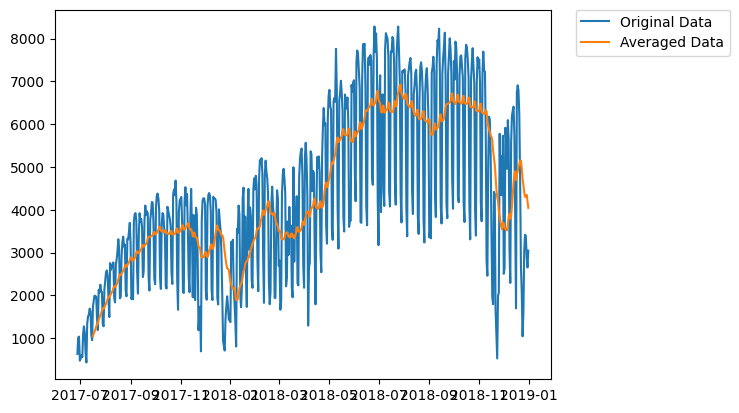

In [ ]:
#plot the original dataset (bike_rides_df) and the averaged dataset (avg_bike_rides_df)
plt.plot(bike_rides_df, label='Original Data')
plt.plot(avg_bike_rides_df, label='Averaged Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**The plot above shows the original time series data alongside the time series after applying the simple moving average filter. It is evident that the resulting time series has been smoothed.**

To better see the effect of the moving average filter:
- I'll set the first 400 days for training and the rest for testing
-  copy the dataframe and add a column to the predicted value with window size of 2

In [ ]:
# select the first 400 observations for training
train_len = 400
train_data = bike_rides_df[0:train_len] # first 400 days as training set.
test_data = bike_rides_df[train_len:] # last 552-400 days as out-of-time test set.

# copy the dataframe and add a column to the predicted value with window size of 2
sma_bike_rides_df =bike_rides_df.copy()
ma_window = 2
sma_bike_rides_df['sma_forecast'] = bike_rides_df['bike_numbers'].rolling(ma_window).mean()


Now let's plot the training, testing data, and the predictions made by the simple moving average on the same graph.

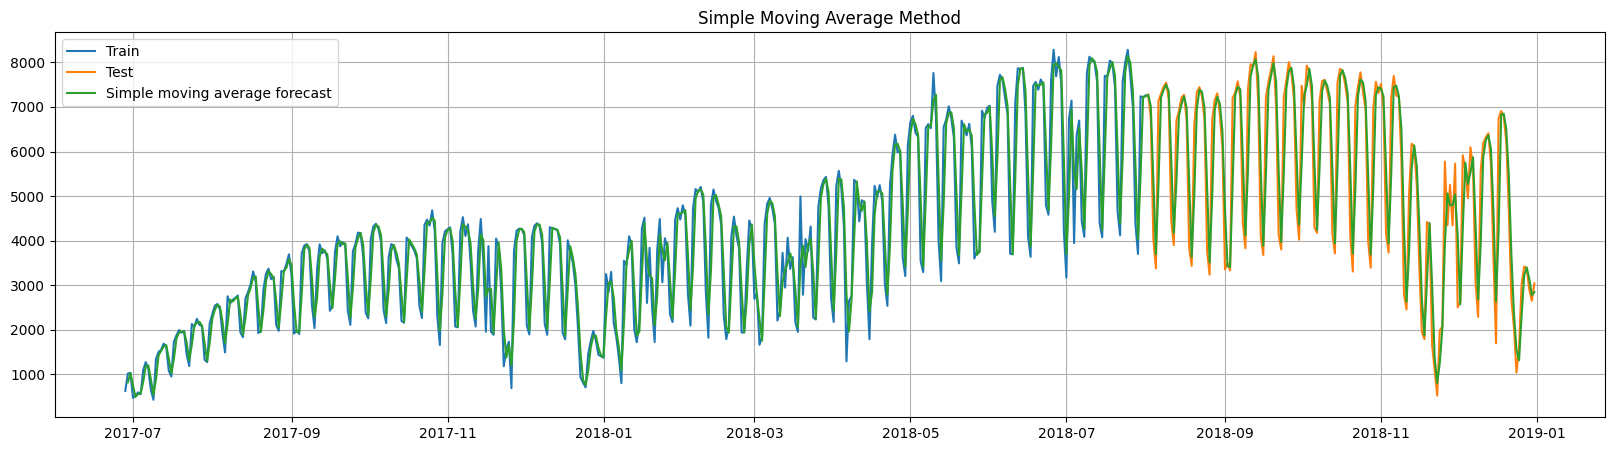

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train_data['bike_numbers'], label='Train')
plt.plot(test_data['bike_numbers'], label='Test')
plt.plot(sma_bike_rides_df['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

**The above plot shows the training and testing sets along with the Simple Moving Average (SMA) forecast applied to the dataset. The SMA method effectively smooths the data, reducing short-term fluctuations and capturing the general trend. However, due to its lagging nature, it may struggle to accurately predict sharp changes or seasonal variations in the data.**

##Calculating the RMSE (Root Mean Squared Error)

In [ ]:
#Evaluating the sma_forecast column of sma_bike_rides_df after applying a moving average with a window size of 2.
from math import sqrt
from sklearn.metrics import mean_squared_error

#calculate the rmse
rmse = sqrt(mean_squared_error(test_data, sma_bike_rides_df['sma_forecast'][train_len:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 855.730


In [ ]:
#Evaluating the bike_numbers column of avg_bike_rides_df after applying a moving average with a window size of 20.
from math import sqrt
from sklearn.metrics import mean_squared_error

#calculate the rmse
rmse = sqrt(mean_squared_error(test_data, avg_bike_rides_df['bike_numbers'][train_len:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1804.657


**Based on the RMSE metric, the moving average with a window size of 2 provides better predictions than the one with a window size of 20, as it has a lower RMSE.**

### Statistical models

In [ ]:
#split the dataset into 2 partitions
split = round(len(bike_rides_df) / 2)
X1, X2 = bike_rides_df[0:split], bike_rides_df[split:]
#calculate each partitions' mean and variance
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3006.913043, mean2=5628.670290
variance1=1482065.054229, variance2=3639977.719987


**Based on the above, we split the dataset into two partitions and calculated their mean and variance. Since the mean of X1 (partition 1) differs from the mean of X2 (partition 2) and variance of X1 (partition 1) differ from the variance of X2 (partition 2) , we conclude that the time series is non-stationary.**

In [ ]:
# Perform the ADF test to check if the bike_rides_df is stationary
result = adfuller(bike_rides_df['bike_numbers'])  # Apply to your time series column
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")


ADF Statistic: -2.1309815696235668
p-value: 0.23224057987614066
Critical Values: {'1%': -3.442701754304053, '5%': -2.866988120523906, '10%': -2.5696716542766693}
Fail to reject the null hypothesis: The time series is non-stationary.


**Based on the Augmented Dickey-Fuller (ADF) Test, the time series is non-stationary since the p-value > 0.05 null hypothesis is rejected.**

**Since the mean of X1 (partition 1) differs from the mean of X2 (partition 2) and variance of X1 (partition 1) differ from the variance of X2 (partition 2) differ, we conclude that the time series is non-stationary.**

##Differencing

<Axes: xlabel='date'>

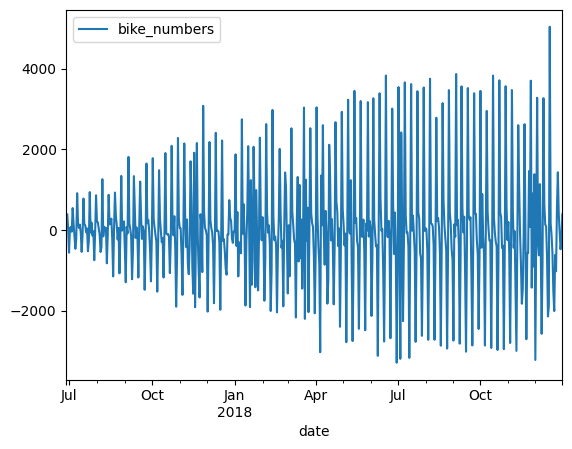

In [ ]:
#Perform differencing to make data stationary
diff = bike_rides_df.diff()
diff.plot()

In [ ]:
diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 2017-06-28 to 2018-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bike_numbers  551 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


In [ ]:
diff.isnull().sum()

,0
bike_numbers,1


In [ ]:
diff.dropna(inplace=True)

In [ ]:
diff.isnull().sum()

,0
bike_numbers,0


In [ ]:
diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 551 entries, 2017-06-29 to 2018-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bike_numbers  551 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


In [ ]:
# Perform the ADF test to check if the diff (result of performing differencing on bike_rides_df) is stationary
#Check stationarity
result = adfuller(diff['bike_numbers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")


ADF Statistic: -7.362237
p-value: 0.000000
Reject the null hypothesis: The time series is stationary.


Text(0.5, 1.0, 'Partial Autocorrelation')

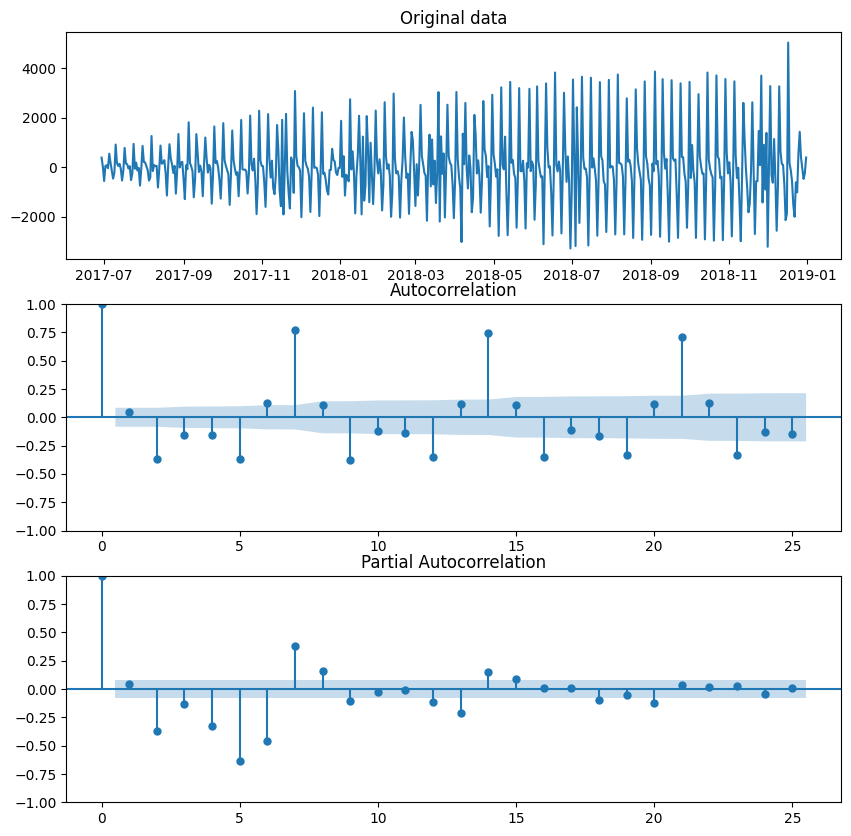

In [ ]:
#plotting differenced data ,acf and pacf plots after applying differencing

fig, axes = plt.subplots(nrows=3, ncols=1,
                         sharex= False, sharey=False, figsize=(10, 10))
ax = axes.ravel()
ax[0].plot(diff)
ax[0].set_title('Original data')

fig = plot_acf(x=diff, lags=25,ax=ax[1])
ax[1].set_title('Autocorrelation')

fig = plot_pacf(diff, lags=25,ax=ax[2])
ax[2].set_title('Partial Autocorrelation')

##Square Root Transformation and Differencing

In [ ]:
# Apply square root transformation
sqrt_bike_rides_df= np.sqrt(bike_rides_df)
# Apply differencing and drop Nan values
sqrt_bike_rides_df= sqrt_bike_rides_df.diff().dropna()


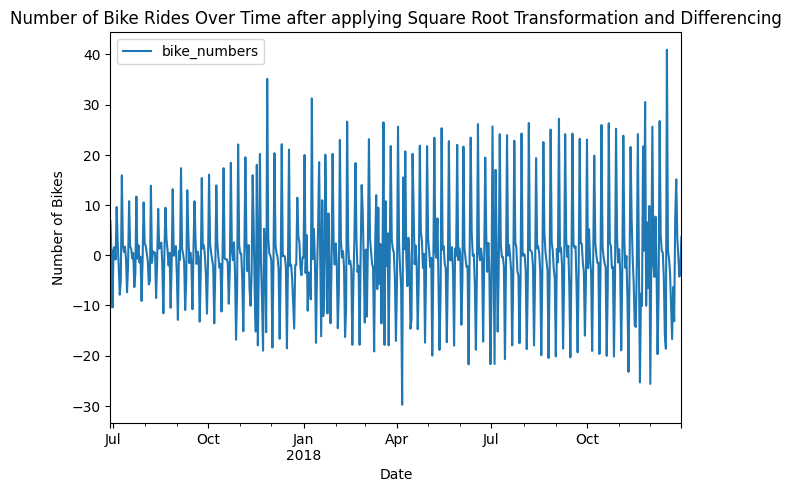

In [ ]:
# plot the sqrt_bike_rides_df
sqrt_bike_rides_df.plot()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.xlabel('Date')
plt.ylabel('Number of Bikes')
plt.title('Number of Bike Rides Over Time after applying Square Root Transformation and Differencing')
plt.show()

In [ ]:
# apply adf test
result = adfuller(sqrt_bike_rides_df['bike_numbers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")



ADF Statistic: -7.477284
p-value: 0.000000
Reject the null hypothesis: The time series is stationary.


Text(0.5, 1.0, 'Partial Autocorrelation')

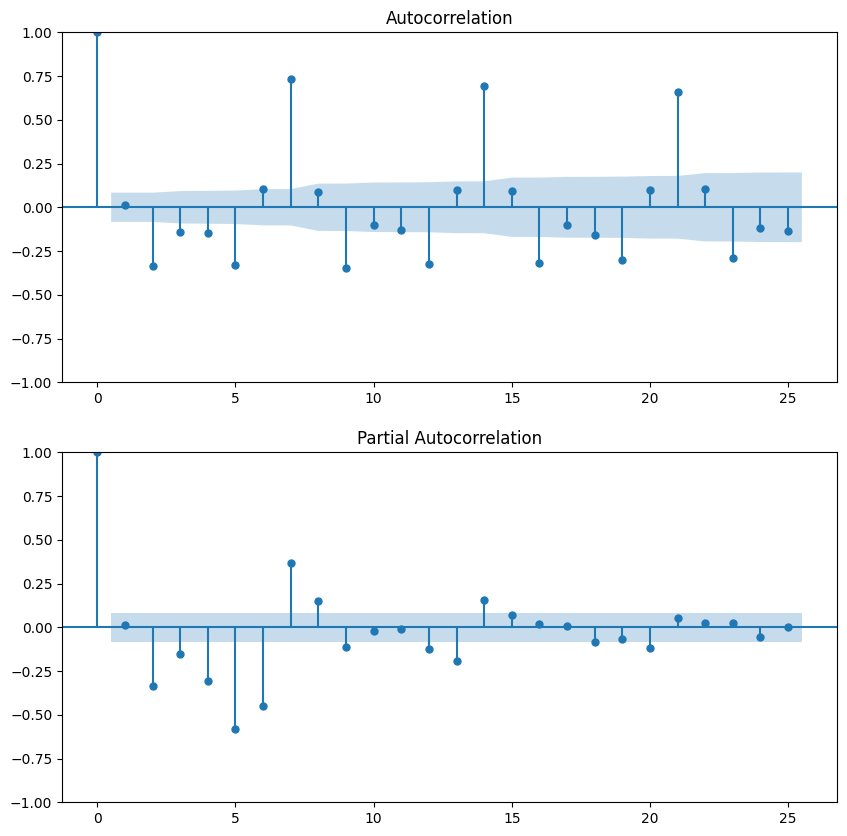

In [ ]:
#plot the ACF and PACF plots for sqrt_bike_rides_df (resulted dataset of applying square root transfromation then differencing)
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex= False, sharey=False, figsize=(10, 10))
ax = axes.ravel()
fig = plot_acf(x=sqrt_bike_rides_df, lags=25,ax=ax[0])
ax[0].set_title('Autocorrelation')

fig = plot_pacf(sqrt_bike_rides_df, lags=25,ax=ax[1])
ax[1].set_title('Partial Autocorrelation')

##Split the sqrt_bike_rides_df (resulted dataset of applying square root transformation then differencing) into train and test sets

In [ ]:
train_len = 400
train_sqrt_bike_rides_df = sqrt_bike_rides_df[0:train_len] # first 400 days as training set.
test_sqrt_bike_rides_df = sqrt_bike_rides_df[train_len:] # last 151 days as  test set.

##Apply Statistical Modeling

In [ ]:
!pip3 uninstall statsmodels -y
!pip3 install numpy scipy patsy pandas
!pip3 install statsmodels


Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Successfully uninstalled statsmodels-0.14.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.1 MB/s eta 0:00:00


###AR Model Order of 20

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
#apply Auto Regressive model
# train the model
ARmodel = AutoReg(train_sqrt_bike_rides_df, lags =20).fit()

# Use the model to make predictions on the test data and evaluate it
ARpred = ARmodel.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_ar = sqrt(mean_squared_error(test_sqrt_bike_rides_df, ARpred))
print('Test RMSE: %.3f' % rmse_ar)

Test RMSE: 8.757


Plotting Test actual values against AR Model of order(20) predictions

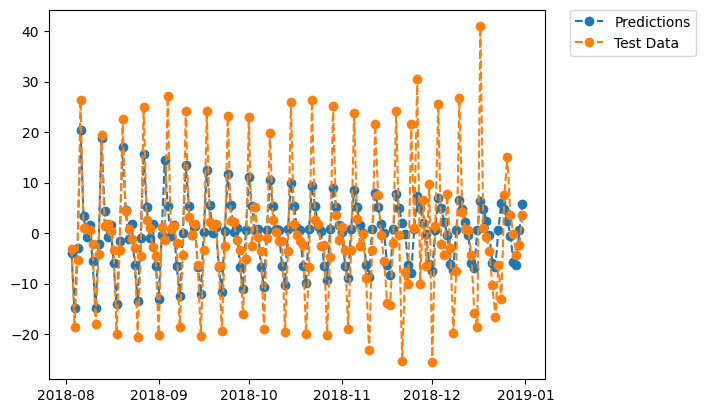

In [ ]:
plt.plot(ARpred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**Based on the above plot, there is a significant gap between actual values and the predicted values**

##SARIMAX model with order (0,0,2), it primarily represents a Moving Average (MA) model

In [ ]:
MAmodel = SARIMAX(train_sqrt_bike_rides_df, order = (0,0,7)).fit()
MApred = MAmodel.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_ma = sqrt(mean_squared_error(test_sqrt_bike_rides_df, MApred))
print('Test RMSE: %.3f' % rmse_ma)

Test RMSE: 12.573


Plotting Test actual values against MA Model of order(7) predictions

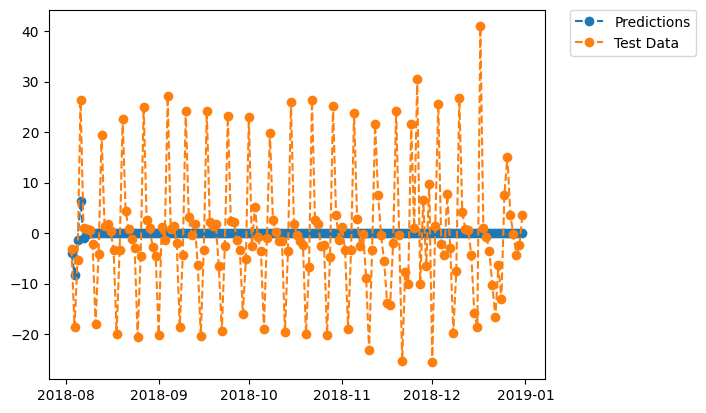

In [ ]:
plt.plot(MApred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**Based on the RMSE and the above plot, I deduced that moving average model is not the right approach for this time series data.**

##SARIMAX model with order (20,0,7), it primarily represents an ARMA Model

In [ ]:
#ARMA Model of (20,0,7) p= 20, d= 0, q= 7
ARMAmodel = SARIMAX(train_sqrt_bike_rides_df, order = (20,0,7)).fit()
ARMApred = ARMAmodel.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_arma = sqrt(mean_squared_error(test_sqrt_bike_rides_df, ARMApred))
print('Test RMSE: %.3f' % rmse_arma)

Test RMSE: 8.239


Plotting Test actual values against ARMA Model (20,0,7) predictions

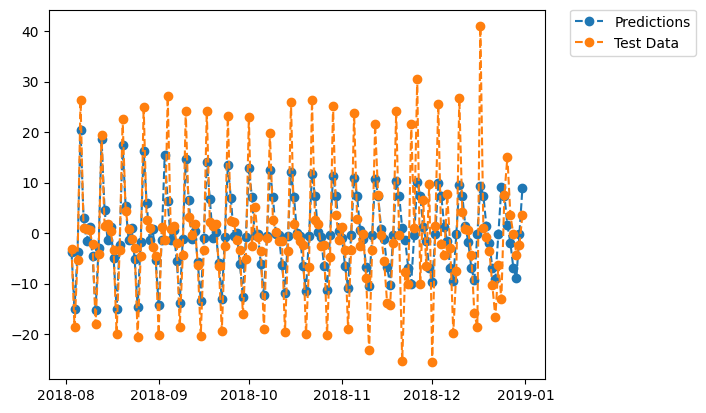

In [ ]:
plt.plot(ARMApred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

##SARIMAX MODEL of order (20,2,7), primarily representing ARIMA Model.

In [ ]:

# ARMAmodel
ARIMAmodel = SARIMAX(train_sqrt_bike_rides_df, order = (20, 2, 7))
# train the model
ARIMAmodel = ARIMAmodel.fit()

# Use the model to make predictions on the test data and evaluate it
ARIMApred = ARIMAmodel.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_arima = sqrt(mean_squared_error(test_sqrt_bike_rides_df, ARIMApred))
print('Test RMSE: %.3f' % rmse_arima)

Test RMSE: 8.463


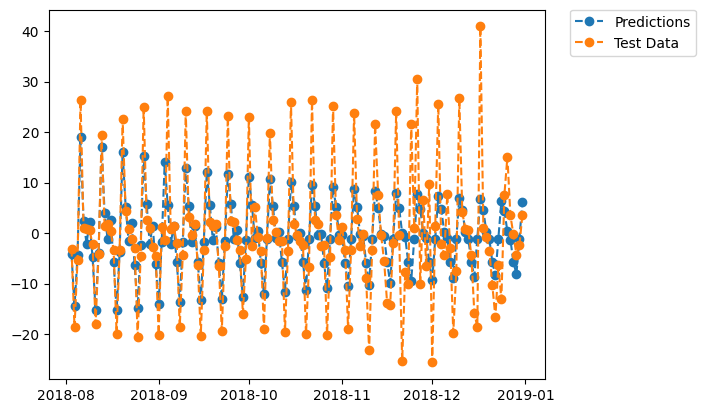

In [ ]:
plt.plot(ARIMApred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

##SARIMAX model with 2 options

Nonseasonal components (for nonseasonal part of the model) order(1,1,2) and the  seasonal components (for the seasonal part of the model) order (20,1,7,7) which represent (p,d,q,s) s stands for seasonal suspecting a weekly seasonality.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
model = SARIMAX(train_sqrt_bike_rides_df,
                order=(1,1,2),
                seasonal_order=(20,1,7,7))

# Fit the model
results = model.fit()

# Summary of the model
print(results.summary())

# Plot predictions
modelPred = results.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_model = sqrt(mean_squared_error(test_sqrt_bike_rides_df, modelPred))
print('Test RMSE: %.3f' % rmse_model)



                                               SARIMAX Results                                                
Dep. Variable:                                           bike_numbers   No. Observations:                  400
Model:             SARIMAX(1, 1, 2)x(20, 1, [1, 2, 3, 4, 5, 6, 7], 7)   Log Likelihood               -1211.560
Date:                                                Wed, 05 Feb 2025   AIC                           2485.120
Time:                                                        23:35:51   BIC                           2608.229
Sample:                                                    06-29-2017   HQIC                          2533.911
                                                         - 08-02-2018                                         
Covariance Type:                                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

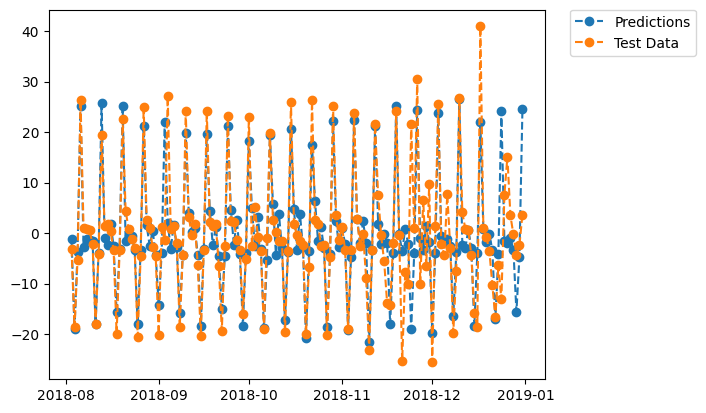

In [ ]:
plt.plot(modelPred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

##SARIMAX model with 2 options

 Nonseasonal components (for nonseasonal part of the model) order(1,1,2) and the  seasonal components (for the seasonal part of the model) order (2,1,2,7) which represent (p,d,q,s) s stands for seasonal suspecting a weekly seasonality

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
model = SARIMAX(train_sqrt_bike_rides_df,
                order=(1,1,2),
                seasonal_order=(2,1,2,7))

# Fit the model
results = model.fit()

# Summary of the model
print(results.summary())

# Plot predictions
modelPred = results.predict(start=test_sqrt_bike_rides_df.index.min(), end=test_sqrt_bike_rides_df.index.max())

rmse_model = sqrt(mean_squared_error(test_sqrt_bike_rides_df, modelPred))
print('Test RMSE: %.3f' % rmse_model)



                                     SARIMAX Results                                     
Dep. Variable:                      bike_numbers   No. Observations:                  400
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -1223.221
Date:                           Thu, 06 Feb 2025   AIC                           2462.443
Time:                                   00:11:28   BIC                           2494.213
Sample:                               06-29-2017   HQIC                          2475.034
                                    - 08-02-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3298      0.053      6.250      0.000       0.226       0.433
ma.L1         -1.8187      0.092    -19.814

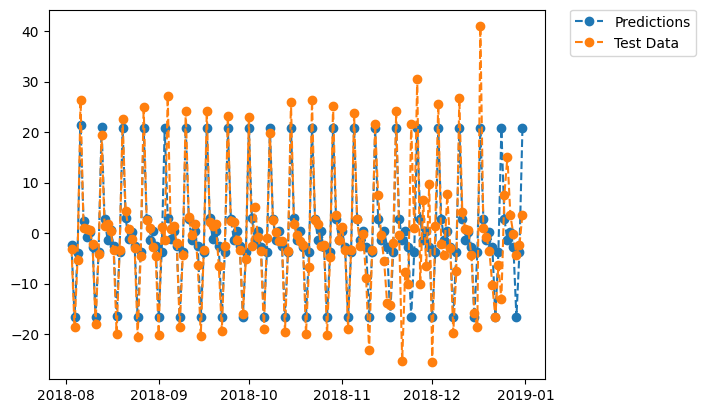

In [ ]:
plt.plot(modelPred, linestyle='--', marker='o', label='Predictions')
plt.plot(test_sqrt_bike_rides_df, linestyle='--', marker='o', label='Test Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**It is evident in the above plot that the residuals and the gaps decreased between some actual values and predicted values.**

**I tried all statistical models yet none of these models was good at simulating the behavior of this dataset.This may be caused by several reasons:**


*   **Data may be not having a certain pattern that can be simulated with some statistical models.**

